# Disclaimer

*Functions called that do not respect a __require callback__ in solidity display as errors in Jupyter Notebook, please only refer to the __message string__ at the beginning of the error message which represents what the customer would see (i.e. exceeding goal amount by X amount.*

# Abstract

In this notebook we will present the preliminary __smart contract__ created in the context of a university project regarding the application of __Blockchain technology__ in the NGO industry with the main purpose being to __combat fraud__ in this sensitive sector. <br> <br>
The key aspect of the contract will be its __immutable mission, location, goal and deadline__ once deployed as well as the presence of a __consensus-based payment function__ as a safety feature to combat __embezzlement__.

# Package Imports 

In [1]:
from web3 import Web3
from IPython.display import Image
import pandas as pd
import json
import os
import requests

*__N.B.__ if you desire to run the notebook you will need to open a __Ganache__ application to simulate different ether wallets. You will also need to adjust keys and server urls. <br>
Additionally, the __coinapi key__ is the free version and only allows for 100 requests per day, if passed, please retrieve your own free key on the website: https://www.coinapi.io/*

# Contract

Contract coded and compiled in __Remix__ official ethereum compiler: <br>

*__N.B.__ please refer to comments in the copy and paste code hereafter for description of function uses.*

_______________________________________________________________________________________________________________________________

# Using the Contract

## Context:

For the purpose of this example, we will imagine that the NGO using our contract model desires to fundraise a project with the purpose of creating a __well__ in __Malawi, East Africa__. <br>
According to __Water Wells for Africa (WWFA)__ the average cost is around __8,000 dollars__ and we will assume the project aims to have a deadline for fundraising and completion of the project of __2 months__. 

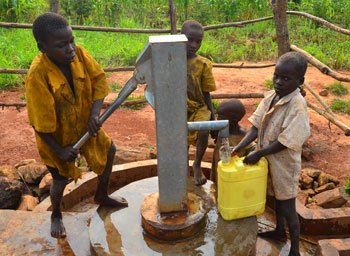

In [2]:
Image(filename='sponsor-a-well-2.jpg') 

## Step 1: Contract Deployment (Admin Only)

The initial step is to connect to the __Ganache app server__ to profit from the 10 ethereum wallets it offers, we then define the __admin account___ as the first of the list and then provide the parameters to the contract through the __abi__ and __bytecode__ provided by the Remix compiler.

In [3]:
# connect to ganache - option #2
ganache_url = "HTTP://127.0.0.1:7545"
web3 = Web3(Web3.HTTPProvider(ganache_url))

# setup default account
web3.eth.defaultAccount = web3.eth.accounts[0]
private_key_default = '32dc00838ac6c16f88b75dc3bc8f2717fd52ffbbd7d70966496d9daa84f6b679'

# get contract abi and bytecode to deploy locally
abi = json.load(open('contracts/abi_v2.json'))
bytecode = json.load(open('contracts/bytecode_v2.json'))

# deploy temporary contract 
temp_contract = web3.eth.contract(bytecode=bytecode['object'], abi=abi)

Second step is to use the __constructor function__ to define the __static immutable variables__ and __deploy__ the contract on the __blockchain__. <br> <br>

To define the __right goal amount__ and __deadline__ we will right utility python functions to convert to the write metrics being __wei__ and __block number__ respectively. But first we need to retrieve the current __ethereum exchange rate__.

In [4]:
# assign for key provided by coinapi
FREE_KEY = '9F6E98D2-537F-4DF0-BA57-3F33AF31C2FE'

API_KEY = os.environ.get('COINAPI_KEY', FREE_KEY)
headers = {'X-CoinAPI-Key': API_KEY}

# request exchange rate, here usd and ether
resp = requests.get('https://rest.coinapi.io/v1/exchangerate/ETH/USD', headers=headers)

resp.json()

{'time': '2019-12-12T15:21:11.5877898Z',
 'asset_id_base': 'ETH',
 'asset_id_quote': 'USD',
 'rate': 142.92335165757592}

In [5]:
def dollar_to_wei(dollar_value, exchange_rate):
    """
    inputs:
    - dollar_value: float or integer
        Amount of money in dollars required to finish project.
    - exchange_rate: float
        Value of the exchange rate between ether and dollar provided by the coinapi.
        
    return:
    - temp_wei: integer
        Integer (required for solidity format) Wei value of the total amount of money needed for project.
    """
    # convert dollar amount into ether amount
    temp_ethers = dollar_value / exchange_rate
    
    # convert ether into wei
    temp_wei = int(temp_ethers * 1000000000000000000)
    
    return temp_wei

def deadline_to_blocknumber(deadline):
    """
    input:
    - deadline: integer
        For ease, this integer represents the number of days to deadline.
        
    return:
    - num_blocks: integer
        Number of minable blocks before deadline is passed for Blockchain to keep track.
    """
    # convert days to seconds
    temp_secs = deadline * 24 * 60 ** 2
    # ethereum blocktime is around 10 to 20 seconds with an average at 12 seconds so we will use this value
    num_blocks = int(temp_secs // 12)
    
    return num_blocks

Before construction of the contract, lets use the utility functions to get __real time wei value__ of the dollar amount and convert the deadline into __number of minable blocks__.

In [6]:
# get exchange rate
ether_usd_rate = resp.json()['rate']

# get wei value of goal
wei_goal = dollar_to_wei(8000, ether_usd_rate)

# get number of blocks before deadline
# say 2 months is 60 days
num_block_deadline = deadline_to_blocknumber(60)

We can now call the __constructor__ by feeding it the right parameters:

In [7]:
# deploy actual contract and assign static variables
mission = 'Building a well.'
location = 'Malawi, East Africa.'
deadline = num_block_deadline
goal = wei_goal

tx_hash = temp_contract.constructor(mission, location, deadline, goal).transact()
tx_receipt = web3.eth.waitForTransactionReceipt(tx_hash)

# Create the contract instance with the newly-deployed address
contract = web3.eth.contract(address=tx_receipt.contractAddress, abi=abi)

In [8]:
# verify contract info
print('Goal: ' + str(contract.functions.goal().call()))
print('Deadline: ' + str(contract.functions.deadline().call()))
print('Project mission: ' + str(contract.functions.mission().call()))
print('Project location: ' + str(contract.functions.location().call()))

Goal: 55974058173270843392
Deadline: 432088
Project mission: Building a well.
Project location: Malawi, East Africa.


## Step 2: Testing Donation Function and its Requirements

Firtly, lets make sure the project has an __initial balance of 0__.

In [9]:
# check balance before any contribution
print(contract.functions.getBalance().call())

0


Lets now use the first __5 non admin accounts__ to donate __most__ of the amount.

In [10]:
# divide total amount required by 6 donations
donate_amount = wei_goal // 6

# retrieve missed amount for completion later
missing_donation = wei_goal - donate_amount * 5

# fake 5 contribution
for i in range(1, 6): # use other ganache accounts == not admin
    # send 2 ether per account to add up to goal
    tx_hash_temp = contract.functions.donate().transact({'from': web3.eth.accounts[i], 'gas': 3000000, 'value': donate_amount})
    tx_receipt_temp = web3.eth.waitForTransactionReceipt(tx_hash)

Let's then check that the donation have been __added to contract__.

In [11]:
# check balance after contributions
print(str(contract.functions.getBalance().call()) + ' raised out of ' + 
     str(contract.functions.goal().call()) + ' needed.')

# show missing amount
print('Project is still missing: ' + str(missing_donation) + ' Weis.')

46645048477725702825 raised out of 55974058173270843392 needed.
Project is still missing: 9329009695545140567 Weis.


Use the next account to donate an amount that __exceeds goal__ and check __callback message__.

In [12]:
# make sure more contributions are not accepted
i = 6 # another ganache account not used

# define donation amount as amoount still required + an arbitrary excess
temp_donation_excess = missing_donation + 1000000

tx_hash_temp = contract.functions.donate().transact({'from': web3.eth.accounts[i], 'gas': 3000000, 'value': temp_donation_excess})
tx_receipt_temp = web3.eth.waitForTransactionReceipt(tx_hash)

ValueError: {'message': 'VM Exception while processing transaction: revert Too much donated, project missing: 9329009695545140567', 'code': -32000, 'data': {'0x139ee23a97f30446b4afb6b284ac19ab076e589dee4ebf49a971a848bd5adae3': {'error': 'revert', 'program_counter': 3843, 'return': '0x08c379a000000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000036546f6f206d75636820646f6e617465642c2070726f6a656374206d697373696e673a203933323930303936393535343531343035363700000000000000000000', 'reason': 'Too much donated, project missing: 9329009695545140567'}, 'stack': 'Error: \n    at Function.RuntimeError.fromResults (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\lib\\utils\\runtimeerror.js:89:13)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\lib\\blockchain_double.js:604:28\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\internal\\once.js:12:16\n    at replenish (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\internal\\eachOfLimit.js:61:25)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\internal\\eachOfLimit.js:71:9\n    at eachLimit (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\eachLimit.js:43:36)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\internal\\doLimit.js:9:16\n    at VM.AsyncEventEmitter.emit (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async-eventemitter\\lib\\AsyncEventEmitter.js:42:3)\n    at afterBlock (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\ethereumjs-vm\\dist\\runBlock.js:75:10)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\ethereumjs-vm\\dist\\runBlock.js:252:9\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\ethereumjs-vm\\dist\\state\\stateManager.js:426:9\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:969:16\n    at next (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:5225:18)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:119:16\n    at _combinedTickCallback (internal/process/next_tick.js:131:7)\n    at process._tickCallback (internal/process/next_tick.js:180:9)', 'name': 'RuntimeError'}}

As explained in the __*Disclaimer*__, the message of interest provided to customer would be the __*'message': 'VM Exception while processing transaction: revert Too much donated, project missing: 9228804508617472686'*__.

In [13]:
# make sure money has not gone to contract
contract.functions.raisedAmount().call()

46645048477725702825

For the rest of the notebook, we want the __goal__ to be __achieved__, we will consequently use the latter account to now donate the __exact__ missing amount.

In [14]:
i = 6 # another ganache account not used

tx_hash_temp = contract.functions.donate().transact({'from': web3.eth.accounts[i], 'gas': 3000000, 'value': missing_donation})
tx_receipt_temp = web3.eth.waitForTransactionReceipt(tx_hash)

In [15]:
# check balance after contributions
print(str(contract.functions.getBalance().call()) + ' raised out of ' + 
     str(contract.functions.goal().call()) + ' needed.')

55974058173270843392 raised out of 55974058173270843392 needed.


## Step 3: Add Information Miners (Admin Only)

The __Proof-of-Work__ used for this contract is based on __social consensus__ with __information miners__ voting the approval of __expenses__ with a __required majority__. <br> <br>
Here, __information miners__ are represented by other __NGOs__ providing similar projects with the idea being that the __majority of NGOs__ are not __fraudulent__.

_______________________________________________________________________________________________________________________________

To ease the testing process, we will recycle __some__ of the addresses used for donations. __In practice__, the miners whitelisted would be different to contributors, __unless__ the miner NGO also desires to participate in the crowdfunding. <br> <br>
The __whitelisting__ function to add miners is an __admin only__ function so as to make sure not anyone can *take control of the consensus*.

In [16]:
# add as many unused ganache accounts as NGO information miners to whitelist of consensus voters
for i in range(5, 10):
    contract.functions.addMiner(web3.eth.accounts[i]).transact()
    
# check that miners have been added, should be equal to 5
print('Number of information miners: ' + str(contract.functions.totalMiners().call()))
print('Majority at 3 out of 5.')

Number of information miners: 5
Majority at 3 out of 5.


## Step 4: Create a Payment Request (Admin Only)

In order to create a payment/spending request, the admin of the NGO in charge of the project __must__ provide the following information: <br> <br>
1) A __*description*__ of the service and/or material provided by the recipient. <br><br>
2) The __*recipient address*__ which information miners can use to verify that the money is not being embezzled but sent to the *right wallet address*. <br><br>
3) The __*value amount*__ of the payment which, again, the information miners with their knowledge of the market (being similar NGOs) can verify by comparing to their own *baselines*.

In [17]:
# prepare request parameter
description = 'Payment of breezeblocks for the well construction.'

# use of a ganache donor account as recipient for ease of testing but in practice would be supplier wallet address
recipient = web3.eth.accounts[2] 

# Use of the utility function with an arbitrary price as it is just testing
value = dollar_to_wei(1000, ether_usd_rate)

# create the payment request
contract.functions.createPaymentRequest(description, recipient, value).transact()

HexBytes('0xa3cc74eebb18ceee8b4701fe4851d5fc41394b043e037b83ed9acb3d6b4599ee')

To verify that the contract is running correctly, lets visualise all the necessary prior information:

In [18]:
# check current value of account 2 recipient
old_value = web3.fromWei(web3.eth.getBalance(web3.eth.accounts[2]), 'ether')
print('Recipient account balance prior to payment: ' + str(old_value))

# check if request has been stored in the declared request array
# request index is 0 here as it is the first request, an admin could in practice create multiple requests if desired
request_index = 0
contract.functions.paymentRequests(0).call()

Recipient account balance prior to payment: 64.270928793958431488


['Payment of breezeblocks for the well construction.',
 6996757271658855424,
 '0x665B392ec1573dBe11B6cB00e3285cFCc43E9022',
 False,
 0]

## Step 5: Voting and Payment

First, lets vote with __only 2 miners__ so that *consensus has not been achieved* and verify that payment would not go through.

In [19]:
# use miners to vote approval of the request
for i in [5, 6]:
    contract.functions.voteForPaymentRequest(request_index).transact({'from': web3.eth.accounts[i]})

Try to make payment __without consensus__.

In [20]:
# make the payment without consensus
contract.functions.makePayment(request_index).transact()

ValueError: {'message': 'execution error: revert', 'code': -32000, 'data': {'stack': 'Error: execution error: revert\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\lib\\utils\\gasEstimation.js:12:11\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\ethereumjs-vm\\dist\\runTx.js:74:9\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:969:16\n    at next (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:5225:18)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\ethereumjs-vm\\dist\\state\\cache.js:160:13\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\merkle-patricia-tree\\util.js:51:36\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\merkle-patricia-tree\\node_modules\\async\\lib\\async.js:52:16\n    at done (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\merkle-patricia-tree\\node_modules\\async\\lib\\async.js:246:17)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\merkle-patricia-tree\\node_modules\\async\\lib\\async.js:44:16\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\lib\\database\\levelupobjectadapter.js:110:7\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:473:16\n    at iteratorCallback (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:1064:13)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:969:16\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\level-sublevel\\shell.js:53:51\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\level-sublevel\\nut.js:109:13\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\lib\\database\\filedown.js:64:7', 'name': 'Error'}}

__*Success*__, the contract has not allowed payment to go through with only __2 out of 5 votes__.

Lets now verify that the contract does not allow the __same miner__ to vote __twice__ on the same request:

In [21]:
# try voting with an already voted account
contract.functions.voteForPaymentRequest(request_index).transact({'from': web3.eth.accounts[6]})

ValueError: {'message': 'execution error: revert', 'code': -32000, 'data': {'stack': 'Error: execution error: revert\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\lib\\utils\\gasEstimation.js:12:11\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\ethereumjs-vm\\dist\\runTx.js:74:9\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:969:16\n    at next (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:5225:18)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\ethereumjs-vm\\dist\\state\\cache.js:160:13\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\merkle-patricia-tree\\util.js:51:36\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\merkle-patricia-tree\\node_modules\\async\\lib\\async.js:52:16\n    at done (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\merkle-patricia-tree\\node_modules\\async\\lib\\async.js:246:17)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\merkle-patricia-tree\\node_modules\\async\\lib\\async.js:44:16\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\lib\\database\\levelupobjectadapter.js:110:7\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:473:16\n    at iteratorCallback (C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:1064:13)\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\async\\dist\\async.js:969:16\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\level-sublevel\\shell.js:53:51\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\node_modules\\level-sublevel\\nut.js:109:13\n    at C:\\Program Files\\WindowsApps\\Ganache_2.1.2.0_x64__zh355ej5cj694\\app\\resources\\app.asar\\node_modules\\ganache-core\\lib\\database\\filedown.js:64:7', 'name': 'Error'}}

Again, contract does not permit a miner to __vote twice__ on the same request.

Finally, lets add __votes__ to achieve *consensus*, proceed with payment and verify that request has __status completed == True__. 

In [22]:
# add votes
for i in [7, 8]: # unused whitelisted minors to achieve a 4 out of 5 consensus
    contract.functions.voteForPaymentRequest(request_index).transact({'from': web3.eth.accounts[i]})

# now make the payment
contract.functions.makePayment(request_index).transact()

# check if request has been set to completed
contract.functions.paymentRequests(request_index).call()

['Payment of breezeblocks for the well construction.',
 6996757271658855424,
 '0x665B392ec1573dBe11B6cB00e3285cFCc43E9022',
 True,
 4]

Finally, lets make sure the __recipient address__ has the newly acquired payment on their account:

In [26]:
# check new value of account 2 recipient
new_value = web3.fromWei(web3.eth.getBalance(web3.eth.accounts[2]), 'ether')

# check difference
temp_diff = new_value - old_value

print('New Blance: ' + str(new_value) + '\n' + 'Old balance: ' + str(old_value))
print('Difference is: ' + str(temp_diff) + ' and payment value was: ' + str(value))

New Blance: 71.267686065617286912
Old balance: 64.270928793958431488
Difference is: 6.996757271658855424 and payment value was: 6996757271658855424


*All contract functions and callbacks have now been verified.*